## 1. Import dataset

In [1]:
from helpers import *  
import os

INPUT_DIR = "."
OUT_DIR   = "./out"

os.makedirs(OUT_DIR, exist_ok=True)

FILES = {
    "V1": "V1_first_prompt.txt",
    "V2": "V2_rubric_grade.txt",
    "V3": "V3_improvements_list.txt",
    "V4": "V4_revised_essay.txt",
}

# check files exist
check_files(INPUT_DIR, FILES)


V1 -> V1_first_prompt.txt exists: True
V2 -> V2_rubric_grade.txt exists: True
V3 -> V3_improvements_list.txt exists: True
V4 -> V4_revised_essay.txt exists: True


# 2: Read tokens

In [2]:
v1_path = os.path.join(INPUT_DIR, FILES["V1"])

v1_text = read_text(v1_path)

print(v1_text[:500])  # print first 500 characters

The Relationship Between Social Service Spending and Economic Growth: An Empirical Analysis of OECD Countries 

The relationship between government social spending and economic growth has been a subject of intense academic and policy debate for decades. Traditional economic theory suggests that extensive welfare states may create disincentives to work and investment, potentially hampering economic growth. However, contemporary research presents a more nuanced view, recognizing that social spendi


# 3: Count words

In [8]:
ESSAYS = {}

for key, fname in FILES.items():
    
    ESSAYS[key] = read_text(f"{INPUT_DIR}/{fname}")

list(ESSAYS.keys()), len(ESSAYS["V1"]), len(ESSAYS["V4"])

print("Word counts for V1 and V4 is:")

len(tokens(ESSAYS["V1"])), len(tokens(ESSAYS["V4"]))


Word counts for V1 and V4 is:


(1207, 2662)

# 3: Identify which words are frequently mentioned

In [9]:
# PARAMS
CSV_PATH     = "/Users/ramihuunguyen/Documents/PhD/AI-Assessment/claudeai/causation/causation_transitions.csv"
TOP_AT_LEAST = 4   # e.g., in >= 4 sources
LESS_BELOW   = 3   # e.g., in < 3 sources

import pandas as pd

def build_lexicon_stats(csv_path, top_at_least=4, less_below=3, dedupe=True):
    """
    one-call function:
      - read csv (source, category, phrase)
      - normalize phrases
      - (optional) drop duplicate (source, phrase) rows
      - compute counts per phrase: sources_mentioning, total_mentions
      - return (table, top_list, less_list)
    """
    df = pd.read_csv(csv_path)
    df["phrase_norm"] = df["phrase"].str.strip().str.lower()
    if dedupe:
        df = df.drop_duplicates(subset=["source", "phrase_norm"])

    # both become the same if each source lists a phrase once
    counts = (
        df.groupby("phrase_norm")["source"]
          .nunique()
          .rename("sources_mentioning")
          .sort_values(ascending=False)
          .to_frame()
    )
    counts["total_mentions"] = counts["sources_mentioning"]  # same in your case

    # sort by sources_mentioning then phrase
    table = counts.sort_values(["sources_mentioning", "total_mentions",], ascending=False)

    # buckets
    top_list  = table.query("sources_mentioning >= @top_at_least").index.tolist()
    less_list = table.query("sources_mentioning <  @less_below").index.tolist()

    return table, top_list, less_list

# USE
table, top_list, less_list = build_lexicon_stats(CSV_PATH, TOP_AT_LEAST, LESS_BELOW)
print(table.head(10))
print("TOP:", top_list[:10])
print("LESS:", less_list[:10])


              sources_mentioning  total_mentions
phrase_norm                                     
consequently                   5               5
thus                           5               5
hence                          5               5
therefore                      5               5
as a result                    4               4
so                             3               3
accordingly                    3               3
because                        3               3
then                           2               2
since                          2               2
TOP: ['consequently', 'thus', 'hence', 'therefore', 'as a result']
LESS: ['then', 'since', 'for this purpose', 'subsequently', 'next', 'so then', 'previously', 'otherwise', 'thereupon', 'on account of']


# 4: Causation Words

In [5]:
# =========================
# STEP 0: setup
# =========================
import os, pathlib, pandas as pd

# where your essays live
INPUT_DIR = "."   # change if needed

FILES = {
  "V1": "V1_first_prompt.txt",
  "V2": "V2_rubric_grade.txt",
  "V3": "V3_improvements_list.txt",
  "V4": "V4_revised_essay.txt",
}

# resolve paths
RESOLVED = {k: str(pathlib.Path(INPUT_DIR) / v) for k, v in FILES.items()}

def read_text(path):
    return pathlib.Path(path).read_text(encoding="utf-8", errors="ignore")

# =========================
# STEP 1: causation words
# =========================
TOP_CAUSATION = ["consequently", "hence", "therefore", "thus"]
LESS_CAUSATION = ["as a result", "accordingly", "because", "so", "for this purpose", "since"]

# =========================
# STEP 2: count markers
# =========================
def count_markers(text, markers):
    text = text.lower()
    return {m: text.count(m) for m in markers}

results = {}
for essay_id, path in RESOLVED.items():
    txt = read_text(path)
    results[essay_id] = count_markers(txt, TOP_CAUSATION + LESS_CAUSATION)

# =========================
# STEP 3: table
# =========================
df = pd.DataFrame(results).T  # essays as rows, words as columns
df


,consequently,hence,therefore,thus,as a result,accordingly,because,so,for this purpose,since
V1,0,0,0,0,0,0,0,63,0,1
V2,0,0,0,0,0,0,0,6,0,0
V3,0,0,0,0,0,0,0,7,0,0
V4,0,0,0,0,0,0,1,106,0,3


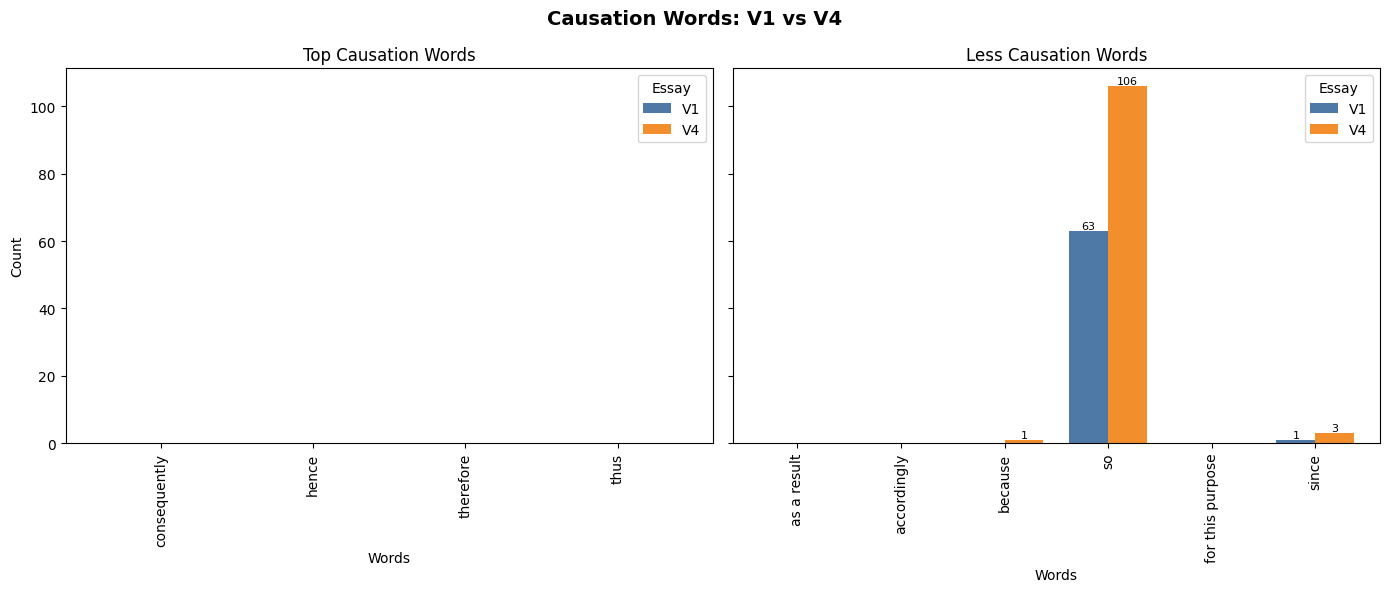

In [6]:
# =========================
# STEP 4: visualization (V1 vs V4; Top vs Less)
# =========================
import matplotlib.pyplot as plt

ESSAYS = ["V1", "V4"]  # focus on V1 and V4 only

# keep only columns that actually exist in df
top_cols  = [w for w in TOP_CAUSATION  if w in df.columns]
less_cols = [w for w in LESS_CAUSATION if w in df.columns]

# subset rows (essays) and columns (word groups)
df_v = df.loc[ESSAYS]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# left: Top causation words
(df_v[top_cols].T).plot(kind="bar", ax=axes[0], width=0.75, color=["#4e79a7", "#f28e2b"])
axes[0].set_title("Top Causation Words")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Count")
axes[0].legend(title="Essay")

# right: Less causation words
(df_v[less_cols].T).plot(kind="bar", ax=axes[1], width=0.75, color=["#4e79a7", "#f28e2b"])
axes[1].set_title("Less Causation Words")
axes[1].set_xlabel("Words")
axes[1].legend(title="Essay")

# add small numbers on bars
for ax in axes:
    for p in ax.patches:
        h = p.get_height()
        if h > 0:
            ax.annotate(
                str(int(h)),
                (p.get_x() + p.get_width() / 2.0, h),
                ha="center", va="bottom", fontsize=8
            )

fig.suptitle("Causation Words: V1 vs V4", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


# 5: Chronology

In [14]:
from lexiconword import*

# PARAMS
CSV_PATH     = "/Users/ramihuunguyen/Documents/PhD/AI-Assessment/claudeai/causation/chronology_transition.csv"
TOP_AT_LEAST = 4   # e.g., in >= 4 sources
LESS_BELOW   = 3   # e.g., in < 3 sources

# USE
table, top_list, less_list = build_lexicon_stats(CSV_PATH, TOP_AT_LEAST, LESS_BELOW)
print(table.head(10))
print("TOP:", top_list[:10])
print("LESS:", less_list[:10])

              sources_mentioning  total_mentions
phrase_norm                                     
next                           5               5
then                           5               5
finally                        4               4
third                          4               4
subsequently                   4               4
second                         4               4
first                          4               4
immediately                    3               3
afterward                      3               3
after                          3               3
TOP: ['next', 'then', 'finally', 'third', 'subsequently', 'second', 'first']
LESS: ['meanwhile', 'later', 'in the meantime', 'previously', 'last', 'earlier', 'during', 'at last', 'at length', 'following']


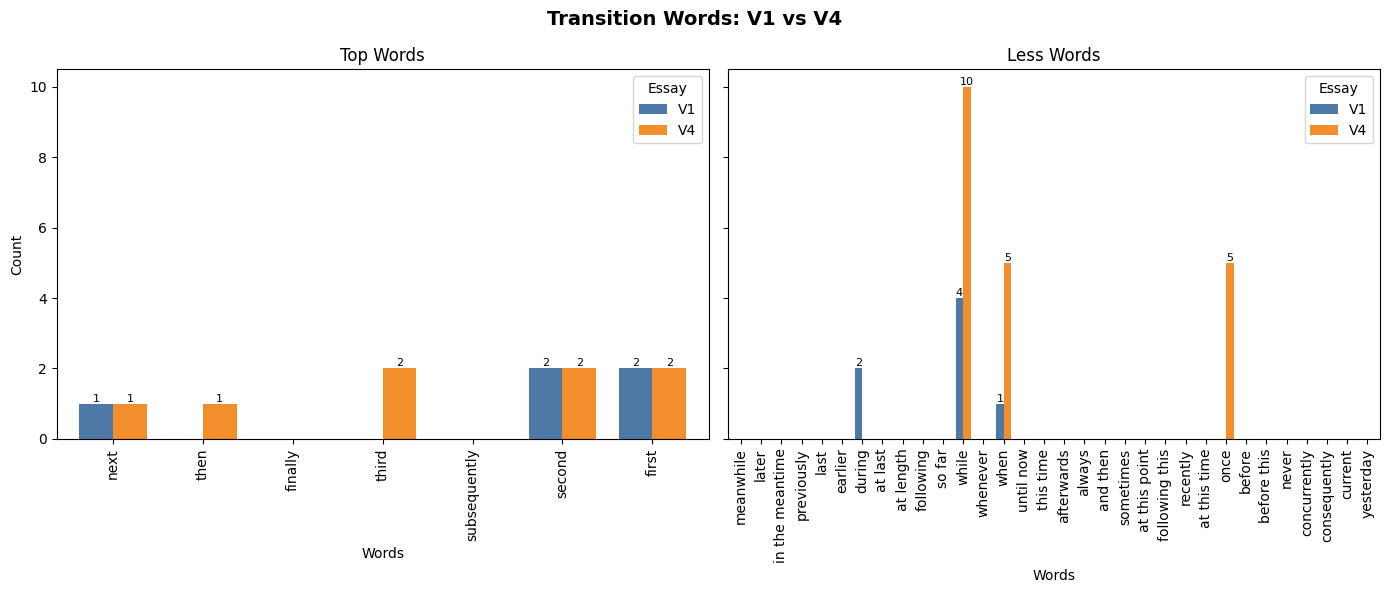

In [17]:
from visualization import*

# 1) get top/less lists from your CSV
table, top_list, less_list = build_lexicon_stats(CSV_PATH, TOP_AT_LEAST, LESS_BELOW)

# 2) count these words in each essay (make sure you have read_text, RESOLVED, and count_markers)
words = top_list + less_list
results = {}
for essay_id, path in RESOLVED.items():
    txt = read_text(path)
    results[essay_id] = {w: txt.lower().count(w) for w in words}

# 3) build the counts df (rows=essays, cols=words)
df_counts = pd.DataFrame(results).T

# 4) now plot using the counts df (NOT the lexicon table)
plot_top_less(df_counts, top_list, less_list, essays=("V1","V4"),
              title="Transition Words: V1 vs V4")
